# LAB 01: MỐI QUAN HỆ CỦA DỮ LIỆU

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from datetime import datetime
import geopandas as gpd
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.set_printoptions(formatter=dict(float='{:0.2f}'.format))
plt.style.use('ggplot')


## 1. Thông tin nhóm

| MSSV     | HỌ VÀ TÊN          |
|:--------:|:-------------------|
| 20127323 | Võ Nhật Tân        |
| 20127447 | Ngô Đức Bảo        |
| 20127275 | Lê Nguyễn Nhật Phú |
| 20127681 | Nguyễn Thiên Phúc  |


## 2. Lấy thông tin từ website

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime, timedelta
from bs4 import BeautifulSoup

In [3]:
def pre_process_html(table_html):
    table_html = table_html.replace('>N/A<', '>-<')
    
    table = BeautifulSoup(table_html)

    def show_data_continent(tag):
        if tag.name == 'th':
            return True
        
        return 'data-continent' in tag.attrs and tag.name in ['td', 'th'] and tag['data-continent'] != ""

    for k, th in enumerate(table.find_all(show_data_continent)):
        raw_s = th.text
        th['style'] = "color: yellow"


    for k, th in enumerate(table.find_all('th')):
        th.string = th.text

    return table.prettify()

In [ ]:
driver = webdriver.Chrome()
driver.maximize_window()

driver.get("https://www.worldometers.info/coronavirus/#main_table")
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "main_table_countries_today")))

#Get updated date
updated_date = driver.find_element(By.CSS_SELECTOR, 'div#page-top+div')
today = datetime.strptime(updated_date.text, "Last updated: %B %d, %Y, %H:%M %Z")

#Get today data
table_element_today = driver.find_element(By.ID, 'main_table_countries_today')
table_html_today = table_element_today.get_attribute('outerHTML')

#Get yesterday data
driver.find_element(By.ID, 'nav-yesterday-tab').click()
table_element_yesterday = driver.find_element(By.ID, 'main_table_countries_yesterday')
table_html_yesterday = table_element_yesterday.get_attribute('outerHTML')

#Get 2-day ago data
driver.find_element(By.ID, 'nav-yesterday2-tab').click()
table_element_yesterday = driver.find_element(By.ID, 'main_table_countries_yesterday2')
table_html_yesterday2 = table_element_yesterday.get_attribute('outerHTML')

driver.quit()

In [ ]:
# Save all collected data to raw_data folder
table_html = pre_process_html('\n'.join([table_html_today, table_html_yesterday, table_html_yesterday2]))
df_list = pd.read_html(table_html, keep_default_na=False)

for day in range(3):
    exp_day = today - timedelta(days=day)
    df_list[day]['DateCollected'] = exp_day.strftime("%d-%m-%Y")
    df_list[day].to_csv(f'./raw_data/{exp_day.strftime("%d-%m-%Y")+"_raw"}.csv', index=False, encoding='UTF-8')

## Tiền xử lý dữ liệu

In [2]:
def pre_process_file(file_path):
    df = pd.read_csv(file_path)

    #Rename the abnormal column's name
    df.rename(columns={'Tot\xa0Cases/1M pop': 'Tot Cases/1M pop'}, inplace=True)

    #Drop the unnecessary columns
    df.drop(columns=['#', 'Serious,Critical'], inplace=True)

    #Drop the total row
    df = df.drop(labels=[len(df) - 1]).reset_index(drop=True)
    
    #Fill the null values and negative values with 0 and replace the NA (-) values by np.nan
    df.fillna(0, inplace=True)
    df._get_numeric_data()[df._get_numeric_data() < 0] = 0
    df.replace(to_replace='-', value=np.nan, inplace=True)

    #Change the type of columns
    columns_name = df.select_dtypes(include='object').columns
    for column_name in columns_name:
        if column_name in ['Country,Other', 'Continent', 'DateCollected'] : continue
        df[column_name] = df[column_name].astype('float')

    #Check if the data has inconsistent values
    sub_df = df.iloc[1:-1, :]

    cal_tot = round(sub_df['TotalCases'] / sub_df['Population'] * 10**6).replace([np.inf, -np.inf], 0)
    cal_deaths = round(sub_df['TotalDeaths'] / sub_df['Population'] * 10**6).replace([np.inf, -np.inf], 0)

    if not np.all(sub_df['Tot Cases/1M pop'] == cal_tot):
        raise Exception(f"Data in the Tot Cases/ 1M pop column is not consistent")
    
    if not np.all(sub_df['Deaths/1M pop'] == cal_deaths):
        raise Exception(f"Data in the Total Deaths column is not consistent")

    return df

In [3]:
#Apply the preprocess to all the file in raw_data and save them to data folder
files = [f for f in listdir('./raw_data/')]
col = []
countries = []


for file in files:
    url = './raw_data/' + file

    df = pre_process_file(url)
    if len(col) == 0 or len(countries) == 0: 
        if len(col) == 0: col = list(df.columns)
        if len(countries) == 0: countries = df['Country,Other'].unique().tolist()
    else:
        if col != list(df.columns):
            warnings.warn(url, ': File is not the same structure')

        diff_contries = list(set(countries) - set(df['Country,Other'].unique().tolist()))
        if len(diff_contries) != 0:
            warnings.warn(f"{url}: this dataset does not contains to some countries: {', '.join(diff_contries)}")

    df.to_csv('./data/' + file.replace('_raw', ''), index=False, encoding='UTF-8')

## Thông tin về dữ liệu

- Mỗi file là thông tin tình hình dịch bệnh Covid-19 trên từng quốc gia theo từng ngày.
- Trong mỗi file có tổng cộng 13 cột:

| Tên thuộc tính   | Ý nghĩa                                                             |
|------------------|---------------------------------------------------------------------|
| Country,Other    | Quốc gia, khác                                                      |
| TotalCases       | Tổng số ca nhiễm đã được ghi nhận                                   |
| NewCases         | Tổng số ca nhiễm mới trong ngày                                     |
| TotalDeaths      | Tổng số ca nhiễm chết người đã được ghi nhận                        |
| NewDeaths        | Tổng số ca nhiễm chết người mới trong ngày                          |
| TotalRecovered   | Tổng số ca nhiễm đã hồi phục đã được ghi nhận                       |
| NewRecovered     | Tổng số ca nhiễm đã hồi phục mới trong ngày                         |
| ActiveCases      | Tổng số ca đang phát hiện bị nhiễm virus                            |
| Tot Cases/1M pop | Tổng số ca nhiễm đã được ghi nhận trên một triệu dân số             |
| Deaths/1M pop    | Tổng số ca nhiễm chết người đã được ghi nhận trên một triệu dân số  |
| TotalTests       | Tổng số lần xét nghiệm (kiểm tra) nhiễm virus                       |
| Tests/ 1M pop    | Tổng số lần xét nghiệm (kiểm tra) nhiễm virus trên một triệu dân số |
| Population       | Dân số của một quốc gia, khác                                       |
| Continent        | Châu lục                                                            |
| DateCollected    | Ngày thu thập thông tin                                             |

## Trực quan hóa dữ liệu

In [2]:
def concatinate_data(filenames, folder_path = './data/'):
    df = pd.DataFrame()

    for file_name in filenames:
        df_cat = pd.read_csv(folder_path + file_name)
        df_cat['DateCollected'] = pd.to_datetime(df_cat['DateCollected'], dayfirst=True)
        df = pd.concat([df, df_cat], axis=0)

    df = df.reset_index()
    df = df.drop(columns={'index'})
    return df

In [3]:
#Concatinate all the data to 1 dataframe
files = [datetime.strptime(f.replace('.csv', ''), '%d-%m-%Y') for f in listdir('./data/')]

days = sorted(files)
df = concatinate_data(map(lambda date: date.strftime("%d-%m-%Y") + '.csv', days))
df.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,Continent,DateCollected
0,World,679742243,75340.0,6798879.0,296.0,652512495.0,104956.0,20430869.0,87205.0,872.2,0.000000e+00,0.0,0.000000e+00,All,2023-02-26
1,USA,105260507,5336.0,1145365.0,19.0,102620644.0,15634.0,1494498.0,314393.0,3421.0,1.166749e+09,3484859.0,3.348053e+08,North America,2023-02-26
2,India,44686202,185.0,530770.0,1.0,44153203.0,104.0,2229.0,31768.0,377.0,9.185351e+08,653003.0,1.406632e+09,Asia,2023-02-26
3,France,39615739,2942.0,164877.0,0.0,39378241.0,718.0,72621.0,604041.0,2514.0,2.714902e+08,4139547.0,6.558452e+07,Europe,2023-02-26
4,Germany,38111063,0.0,167812.0,0.0,37661500.0,2900.0,281751.0,454333.0,2001.0,1.223324e+08,1458359.0,8.388360e+07,Europe,2023-02-26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Country,Other     2784 non-null   object        
 1   TotalCases        2784 non-null   int64         
 2   NewCases          2784 non-null   float64       
 3   TotalDeaths       2784 non-null   float64       
 4   NewDeaths         2784 non-null   float64       
 5   TotalRecovered    2556 non-null   float64       
 6   NewRecovered      2556 non-null   float64       
 7   ActiveCases       2556 non-null   float64       
 8   Tot Cases/1M pop  2784 non-null   float64       
 9   Deaths/1M pop     2784 non-null   float64       
 10  TotalTests        2784 non-null   float64       
 11  Tests/ 1M pop     2784 non-null   float64       
 12  Population        2784 non-null   float64       
 13  Continent         2784 non-null   object        
 14  DateCollected     2784 n

### Tình hình thế giới hiện nay


Đầu tiên, nhóm khảo sát tình hình dịch bệnh trên toàn thế giới để có cái nhìn tổng quan nhất về dịch bệnh

In [5]:
world_data = df[df['Country,Other'] == 'World']
world_data.head(10)

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,Continent,DateCollected
0,World,679742243,75340.0,6798879.0,296.0,652512495.0,104956.0,20430869.0,87205.0,872.2,0.0,0.0,0.0,All,2023-02-26
232,World,679865129,112273.0,6799716.0,705.0,652669816.0,157321.0,20395597.0,87220.0,872.3,0.0,0.0,0.0,All,2023-02-27
464,World,680068046,128801.0,6801130.0,655.0,652820630.0,149957.0,20446286.0,87246.0,872.5,0.0,0.0,0.0,All,2023-02-28
696,World,680261711,143685.0,6802334.0,767.0,653004808.0,173193.0,20454569.0,87271.0,872.7,0.0,0.0,0.0,All,2023-03-01
928,World,680435562,116376.0,6804035.0,722.0,653196665.0,141028.0,20434862.0,87294.0,872.9,0.0,0.0,0.0,All,2023-03-02
1160,World,680538320,102750.0,6804666.0,621.0,653342308.0,145115.0,20391346.0,87307.0,873.0,0.0,0.0,0.0,All,2023-03-03
1392,World,680626732,81870.0,6805021.0,345.0,653456905.0,108525.0,20364806.0,87318.0,873.0,0.0,0.0,0.0,All,2023-03-04
1624,World,680700273,61029.0,6805512.0,292.0,653526300.0,69375.0,20368461.0,87327.0,873.1,0.0,0.0,0.0,All,2023-03-05
1856,World,680788906,64785.0,6806351.0,552.0,653647296.0,117898.0,20335259.0,87339.0,873.2,0.0,0.0,0.0,All,2023-03-06
2088,World,680968133,100234.0,6807855.0,551.0,653825902.0,177791.0,20334376.0,87362.0,873.4,0.0,0.0,0.0,All,2023-03-07


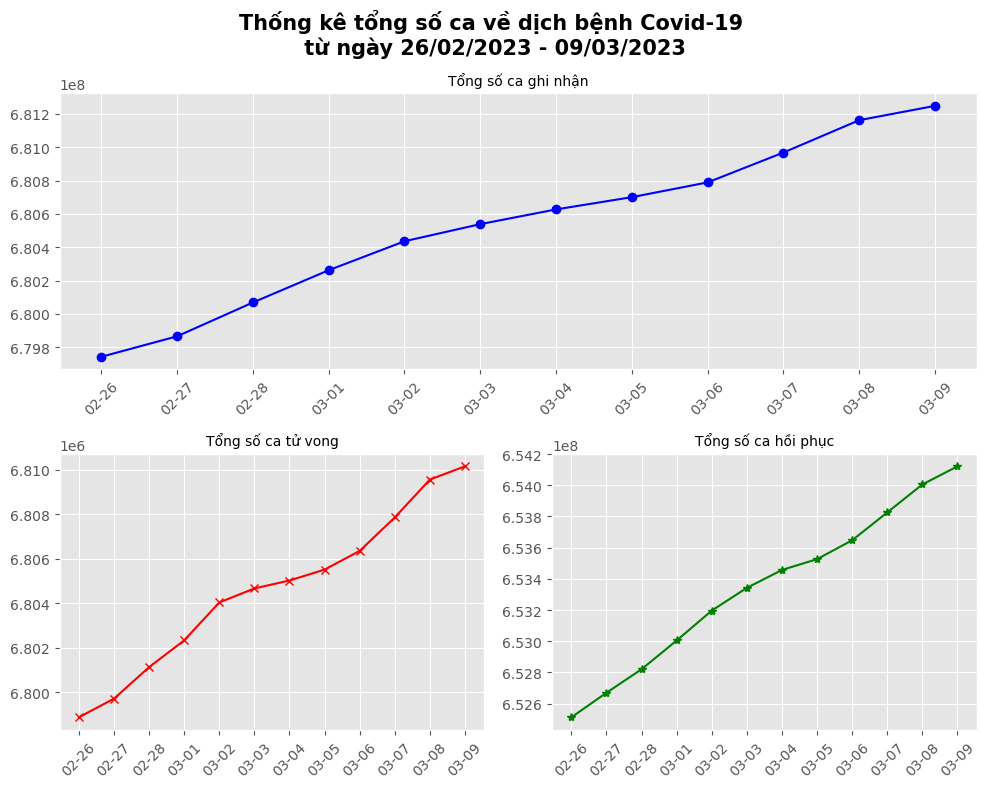

In [6]:
fig = plt.figure()
gs = fig.add_gridspec(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(world_data['DateCollected'], world_data['TotalCases'], color='blue', marker='o',)
ax2.plot(world_data['DateCollected'], world_data['TotalDeaths'], color='red', marker='x')
ax3.plot(world_data['DateCollected'], world_data['TotalRecovered'], color='green', marker='*')

for ax in [ax1, ax2, ax3]:
    labels = world_data['DateCollected'].dt.strftime('%m-%d')

    ax.set_ylim(bottom=None)
    ax.set_xticks(world_data['DateCollected'], labels, rotation=45)

ax1.set_title('Tổng số ca ghi nhận', fontsize=10)
ax2.set_title('Tổng số ca tử vong',  fontsize=10)
ax3.set_title('Tổng số ca hồi phục', fontsize=10)

min_dt, max_dt = world_data['DateCollected'].min(), world_data['DateCollected'].max()
fig.suptitle(f'Thống kê tổng số ca về dịch bệnh Covid-19 \n từ ngày {min_dt.strftime("%d/%m/%Y")} - {max_dt.strftime("%d/%m/%Y")} ', fontsize=15, fontweight="bold")
fig.tight_layout()

**Nhận xét:** 
-	Tốc độ tăng trưởng các ca trên toàn thế giới đang có xu hướng tăng chậm lại. Nguyên nhân chính là do tổng số ca tử vong và tổng số ca hồi phục tăng tương đối nhanh
-	Điều đó ta thấy tình hình Covid trên toàn thế giới được kiểm soát nhờ vào sự gia tăng số ca hồi phục. Tuy nhiên, số lượng ca tử vong ước tính vẫn còn tăng cao. 


### Tình hình giữa các châu lục

In [7]:
#Group by the continent and then pre-process data
countries_df = df[(df['Country,Other'] != 'World') & (df['Continent'] != '0')]
continent_df = countries_df.groupby(['DateCollected', 'Continent']).sum(numeric_only =True).reset_index(level=[0, 1])
continent_df['Tot Cases/1M pop'] = continent_df['TotalCases'] / continent_df['Population'] * 10**6
continent_df['Deaths/1M pop'] = continent_df['TotalDeaths'] / continent_df['Population'] * 10**6
continent_df['TotalRecovered/1M pop'] = continent_df['TotalRecovered'] / continent_df['Population'] * 10**6
continent_df

,DateCollected,Continent,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,TotalRecovered/1M pop
0,2023-02-26,Africa,12792192,766.0,258577.0,1.0,10956539.0,26.0,364186.0,9093.574049,183.814400,1.103003e+08,10896465.0,1.406729e+09,7788.665048
1,2023-02-26,Asia,214254266,36094.0,1536304.0,146.0,182087172.0,55400.0,13472303.0,45476.128400,326.085260,2.373277e+09,92821011.0,4.711357e+09,38648.563543
2,2023-02-26,Australia/Oceania,13994994,1301.0,26110.0,5.0,13776098.0,1190.0,67445.0,321943.010059,600.638485,8.855240e+07,20810364.0,4.347041e+07,316907.492564
3,2023-02-26,Europe,246170589,26377.0,2016458.0,69.0,241656057.0,27649.0,2216782.0,329305.890592,2697.444484,2.823573e+09,212828842.0,7.475438e+08,323266.737065
4,2023-02-26,North America,124553800,6734.0,1610998.0,47.0,119602007.0,17285.0,2438122.0,208234.876880,2693.341915,1.303705e+09,101363029.0,5.981409e+08,199956.237403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2023-03-09,Asia,214639636,33519.0,1538079.0,185.0,182465188.0,29269.0,13477874.0,45557.924370,326.462009,2.376168e+09,92880123.0,4.711357e+09,38728.798604
68,2023-03-09,Australia/Oceania,14027545,1.0,26221.0,0.0,13804466.0,146.0,71143.0,322691.818305,603.191946,8.855310e+07,20811137.0,4.347041e+07,317560.074430
69,2023-03-09,Europe,246803099,34025.0,2021573.0,218.0,242232238.0,49072.0,2267858.0,330152.008196,2704.286893,2.824738e+09,212936168.0,7.475438e+08,324037.502566
70,2023-03-09,North America,124904822,13672.0,1614569.0,170.0,120121902.0,34558.0,2264951.0,208821.731901,2699.312080,1.305629e+09,101419429.0,5.981409e+08,200825.422215


#### Tình trạng hiện tại của mỗi châu lục

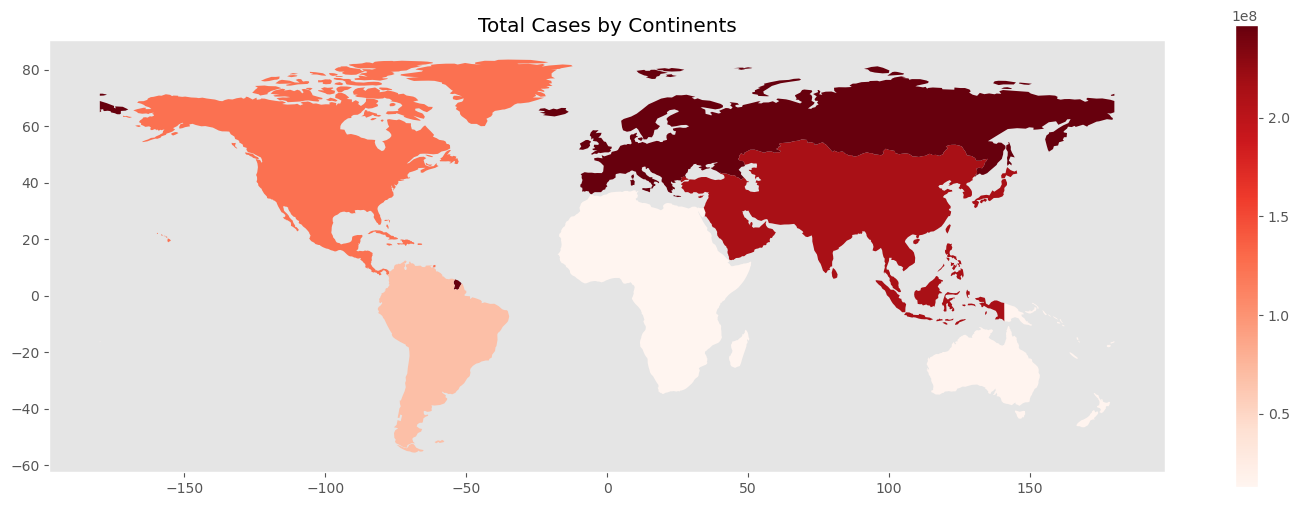

In [29]:
# filter last collected day data, change name to match gpd file
filter_continent_df = continent_df[continent_df['DateCollected'] == continent_df['DateCollected'].max()].copy()
filter_continent_df.loc[filter_continent_df['Continent'] == 'Australia/Oceania', 'Continent'] = 'Oceania'

# get coordinates of each continent
df_world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).drop(['gdp_md_est'], axis=1)
df_world = df_world.dissolve(by='continent', aggfunc='sum' )
df_world.index.name = 'Continent'

df_world = df_world.merge(filter_continent_df, how='left', on='Continent')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
ax.grid(False)

df_world.plot(column='TotalCases', cmap='Reds', legend=True, ax=ax, )
plt.title('Total Cases by Continents');

**Nhận xét**:
-	Tổng số trường hợp nhiễm ghi nhận ở châu Âu và Châu Á chiếm đa số 
-	Châu Đại Dương và châu Phi cũng ghi nhận số ca ít nhất.

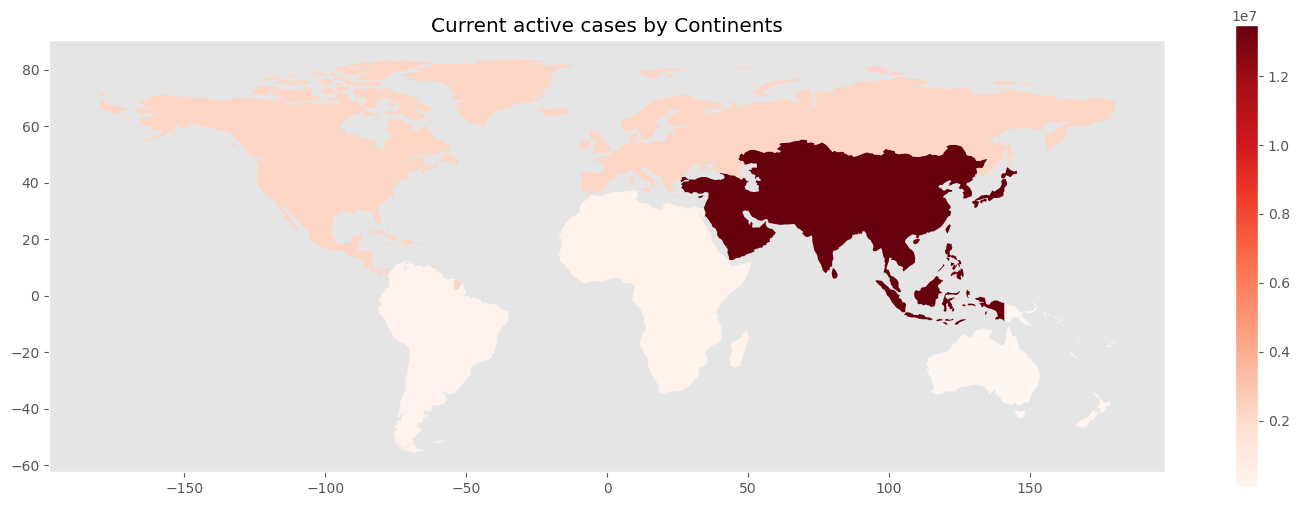

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
ax.grid(False)

df_world.plot(column='ActiveCases', cmap='Reds', legend=True, ax=ax,)
plt.title('Current active cases by Continents');

**Nhận xét**:
- Tuy nhiên số ca hiện tại được ghi nhận ở Châu Âu và Bắc Mỹ tương đối thấp, có thể nói ở giai đoạn đầu số ca ghi nhận ở hai châu lục này khá cao tuy nhiên nhờ sự nỗ lực đã làm giảm số ca trong giai đoạn sau này.

#### Mức độ lây lan ở các châu lục

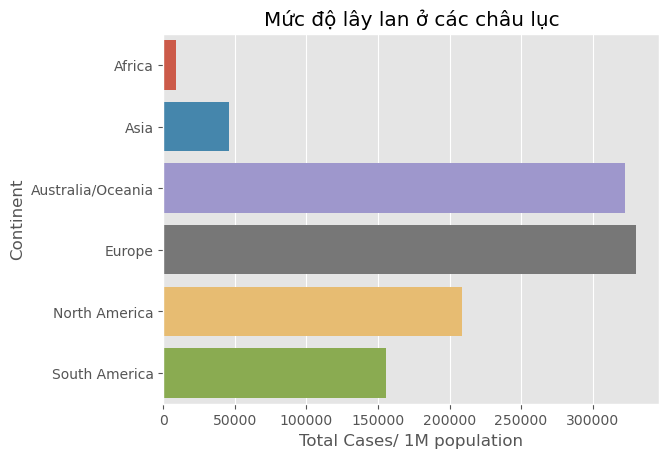

In [10]:
# filter last day data then plot
filter_continent_df = continent_df[continent_df['DateCollected'] == continent_df['DateCollected'].max()]
ax = sns.barplot(x='Tot Cases/1M pop', y='Continent', data=filter_continent_df)
ax.set(xlabel='Total Cases/ 1M population', ylabel='Continent', title='Mức độ lây lan ở các châu lục');

**Nhận xét**:
-	Tốc độ lây lan ở Châu Âu và Châu Đại Dương rất nhanh trong khi ở châu Phi ghi nhận khá chậm.
-	Châu Đại Dương tuy ghi nhận số ca ít nhưng tỷ lệ lây lan khá cao.
-	Đặc biệt ở châu Âu, nếu tiếp tục mức độ lây lan cao có thể dẫn đến tình trạng khó kiểm soát số lượng ca nhiễm

#### Tỷ lệ số ca nhiễm, số ca tử vong (trên số ca nhiễm) và số ca hồi phục (trên số ca nhiễm) giữa các châu lục

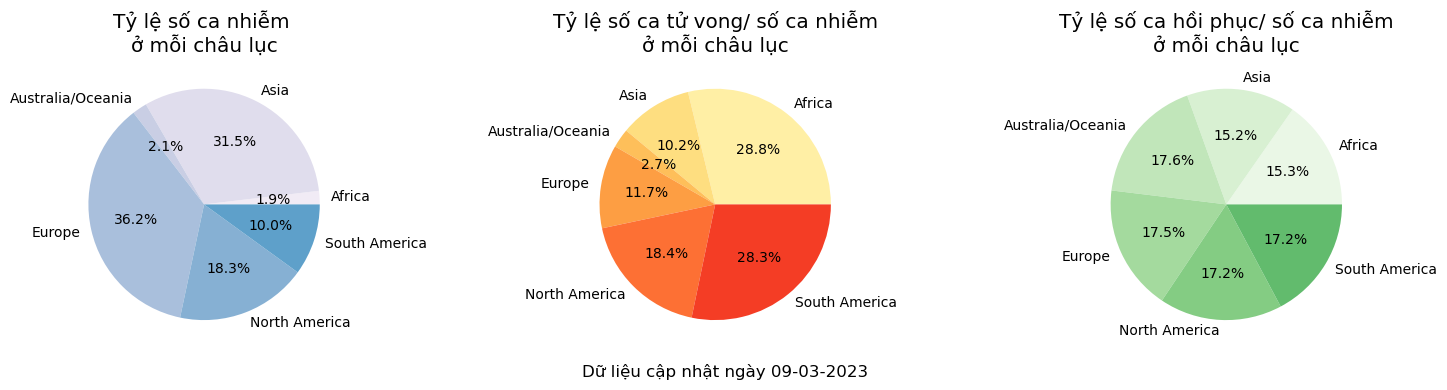

In [11]:
# filter last day data
filter_continent_df = continent_df.loc[continent_df['DateCollected'] == continent_df['DateCollected'].max(), :]

fig, axes = plt.subplots(1, 3)
gs = fig.add_gridspec(2,2)
fig.set_figheight(4)
fig.set_figwidth(15)

axes[0].pie(filter_continent_df['TotalCases'], labels=filter_continent_df['Continent'], autopct='%1.1f%%', colors=sns.color_palette('PuBu', n_colors=10));
axes[1].pie(filter_continent_df['TotalDeaths'] / filter_continent_df['TotalCases'], labels=filter_continent_df['Continent'], autopct='%1.1f%%', colors=sns.color_palette('YlOrRd', n_colors=8));
axes[2].pie(filter_continent_df['TotalRecovered'] / filter_continent_df['TotalCases'], labels=filter_continent_df['Continent'], autopct='%1.1f%%', colors=sns.color_palette('Greens', n_colors=10));

axes[1:]

axes[0].set_title('Tỷ lệ số ca nhiễm \nở mỗi châu lục')
axes[1].set_title('Tỷ lệ số ca tử vong/ số ca nhiễm\nở mỗi châu lục')
axes[2].set_title('Tỷ lệ số ca hồi phục/ số ca nhiễm\nở mỗi châu lục')

date_updated = continent_df['DateCollected'].max().strftime('%d-%m-%Y')

fig.suptitle(f'Dữ liệu cập nhật ngày {date_updated}', y=0)
fig.tight_layout()

**Nhận xét**:
- Các nước ở Châu Đại Dương, Châu Phi có tỉ lệ hồi phục cao: Châu đại dương chiếm 2.1% tổng số ca nhiễm trong đó tỷ lệ tử vong khoảng 2.7%, tỷ lệ ca hồi phục khoảng 17.6%, tương tự đối với Châu Phi 
- Các quốc gia khác đang cho thấy tỷ lệ số ca tử vong cao, đặc biệt là Nam Mỹ khi tổng số ca chỉ chiếm 10% nhưng tỷ lệ tử vong chiếm đến 28.3% tổng số ca tử vong trong khi số ca phục hồi chỉ đạt 17.2%.


### Quốc gia

In [12]:
country_df = df[(df['Country,Other'] != 'World')]

#### Tình hình dịch bệnh ở các quốc gia có tổng số ca mắc cao nhất

Để xem xét tình hình dịch bệnh ở các quốc gia hiện nay, ta khảo sát các ca tử vong mới, các ca nhiễm mới và các ca hồi phục mới những ngày gần đây như thế nào ở các quốc gia

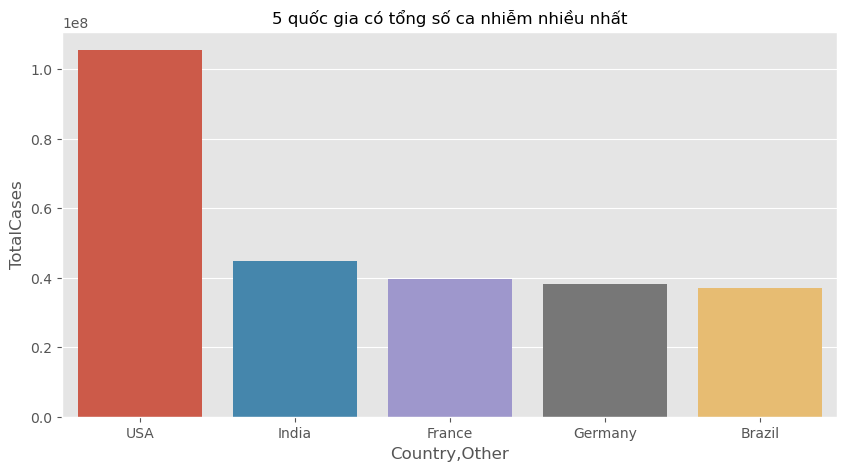

In [13]:
# filter most total cases countries
most_totalcases_country_df = country_df.nlargest(n=5, columns=['DateCollected', 'TotalCases'])
most_totalcases_country_df = countries_df[countries_df['Country,Other'].isin(most_totalcases_country_df['Country,Other'])]

# filter last day data
desired_data = most_totalcases_country_df['DateCollected'] == most_totalcases_country_df['DateCollected'].max()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data= most_totalcases_country_df[desired_data], x='Country,Other', y='TotalCases')
plt.title('5 quốc gia có tổng số ca nhiễm nhiều nhất', fontsize=12);

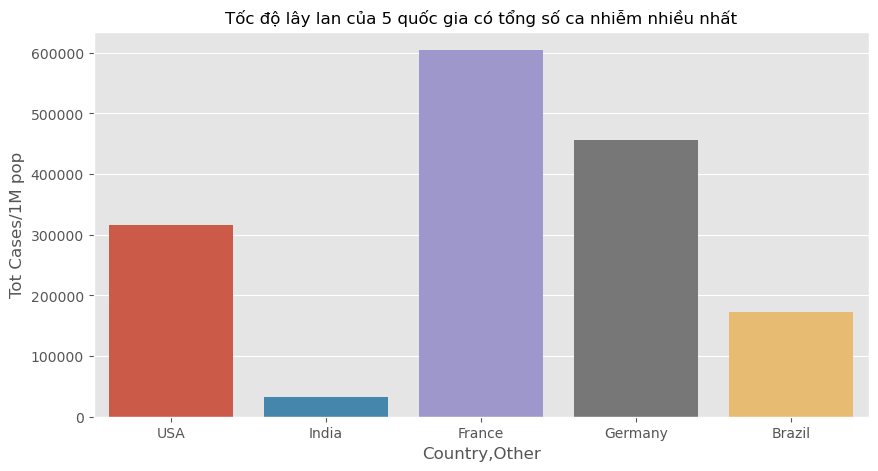

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data= most_totalcases_country_df[desired_data], x='Country,Other', y='Tot Cases/1M pop')
plt.title('Tốc độ lây lan của 5 quốc gia có tổng số ca nhiễm nhiều nhất', fontsize=12);

**Nhận xét**:
* Pháp và Đức có tốc độ lây lan khá cao dù tổng số ca chỉ bằng nửa tổng số ca của Mỹ
* Ấn Độ có tổng số ca đứng thứ 2 nhưng tốc độ nhiễm lại khá thấp

##### Các ca tử vong mới, các ca nhiễm mới và các ca hồi phục mới những ngày gần đây như thế nào ở các quốc gia?

Bằng cách xem xét các ca tử vong mới, các ca nhiễm mới và các ca hồi phục mới, chúng ta có thể thấy tình hình đại dịch ở các quốc gia trong những ngày gần đây.

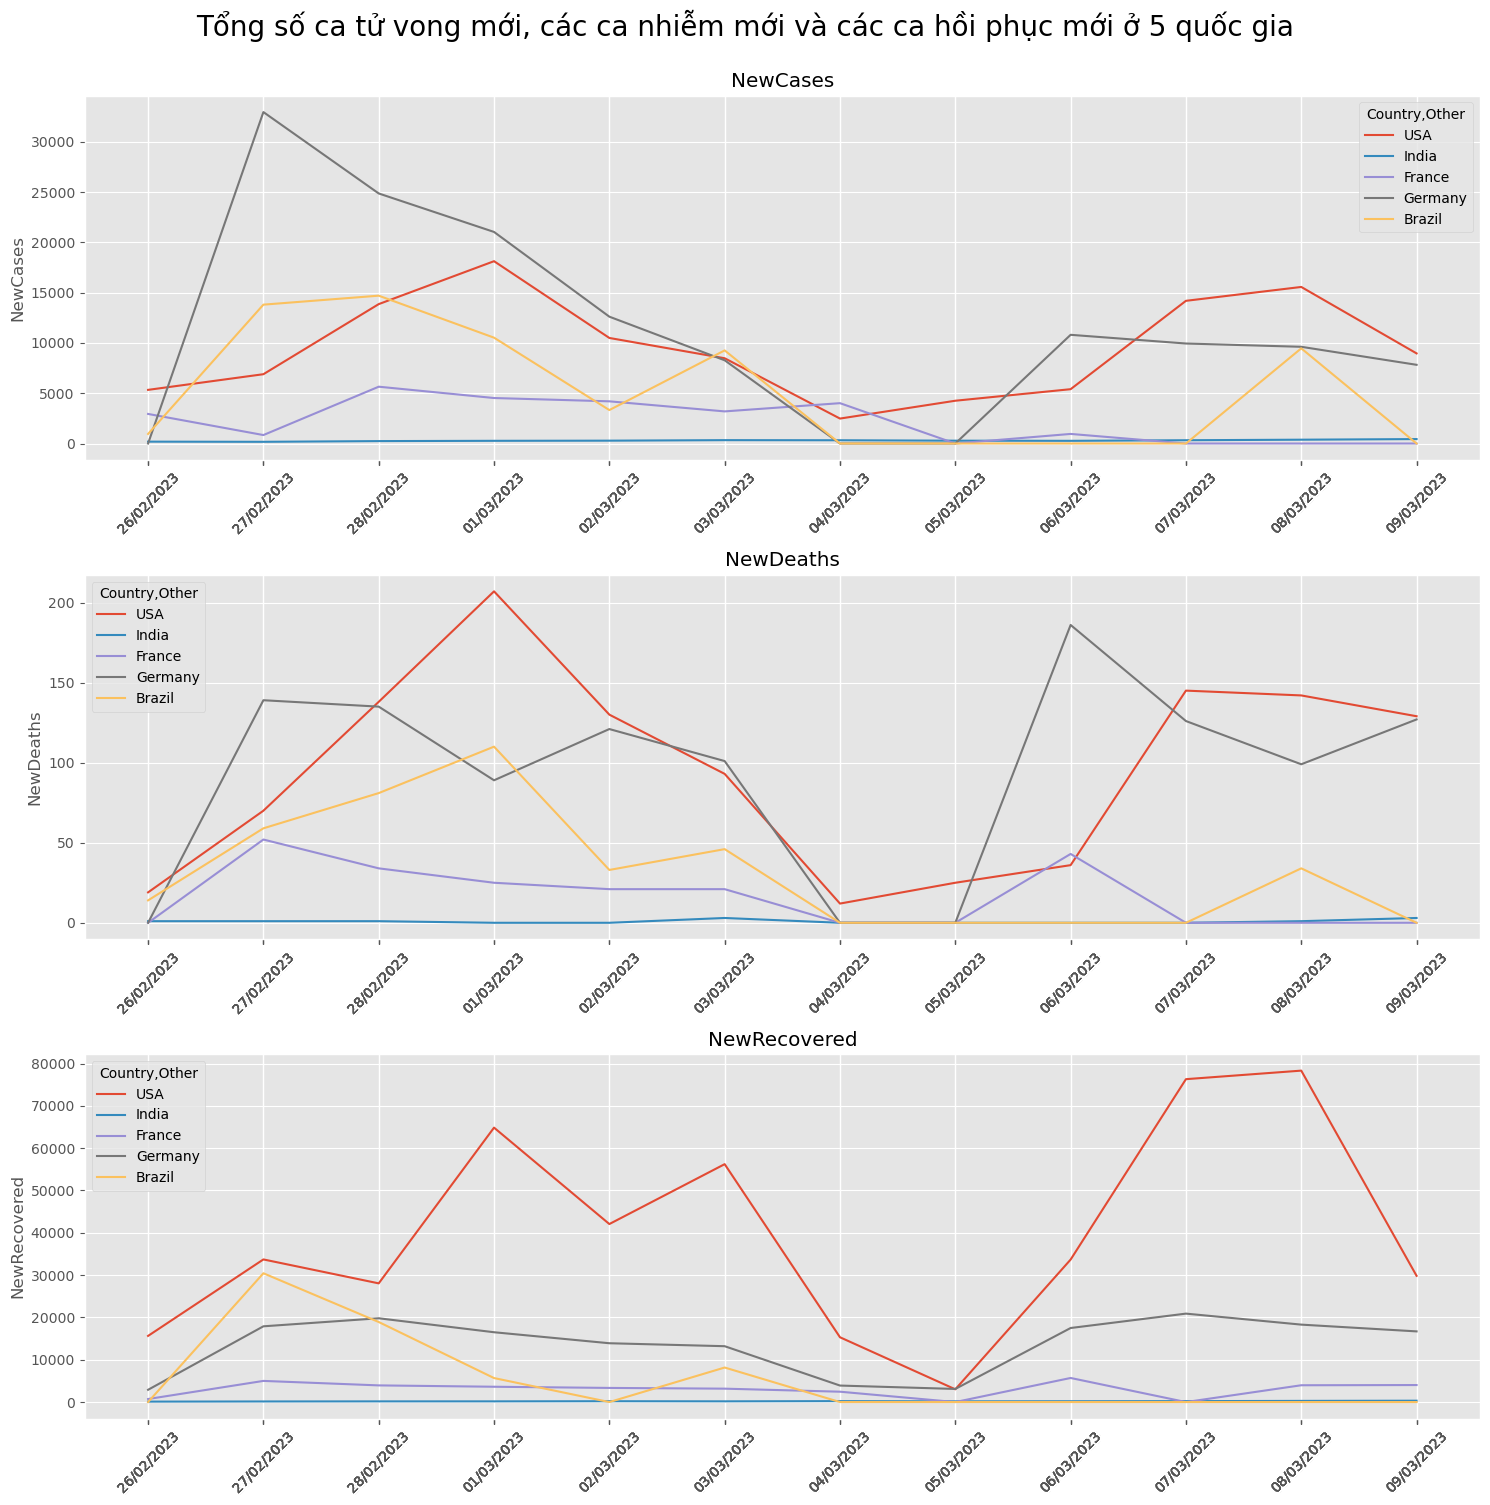

In [14]:
# visualize 3 charts in one figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

y = ['NewCases', 'NewDeaths', 'NewRecovered']
for i in range(3):
    sns.lineplot(ax=ax[i], data= most_totalcases_country_df, x='DateCollected', y= y[i], hue='Country,Other')

    label = most_totalcases_country_df['DateCollected']
    ax[i].set_xticks(label, label.dt.strftime('%d/%m/%Y') ,rotation=45)
    ax[i].set_xlabel('')
    ax[i].set_title(y[i])

fig.suptitle('Tổng số ca tử vong mới, các ca nhiễm mới và các ca hồi phục mới ở 5 quốc gia', fontsize=20, y=1)
fig.tight_layout()

* Từ biểu đồ, có thể thấy đại dịch vẫn đang lan rộng trên thế giới, nhưng đã có một số tín hiệu đáng mừng. Các ca mắc mới và tử vong mới đang giảm và duy trì ở mức thấp, trong khi các ca phục hồi mới đang gia tăng và ổn định ở các quốc gia có nhiều ca nhiễm nhất.
* Trong khi đó, tại Mỹ và Đức những ngày qua số ca mắc mới và tử vong có sự gia tăng đáng kể.
* Mỹ cho thấy họ có Hệ thống chăm sóc y tế tốt vì số ca mắc mới khỏi bệnh luôn cao hơn số ca mắc mới và số ca tử vong.

#### Tình hình chống dịch ở những quốc gia đang có dịch bệnh căng thẳng như thế nào?

Để trả lời câu hỏi này, ta cần làm rõ 3 ý:
* Thế nào là quốc gia đang có dịch bệnh căng thẳng? Đâu là những quốc gia có tình hình dịch bệnh căng thẳng?
* Số ca nhiễm mới của những quốc gia đó như thế nào?
* Số ca hồi phục và số ca chết mới ở những quốc gia đó như thế nào?

##### Thế nào là quốc gia đang có dịch bệnh căng thẳng? Đâu là những quốc gia có tình hình dịch bệnh căng thẳng?

Ở đây em định nghĩa quốc gia đang có dịch bệnh căng thẳng là quốc gia có tổng số lượng ca nhiễm trong khoảng thời gian thu thập thông tin là nhiều nhất.

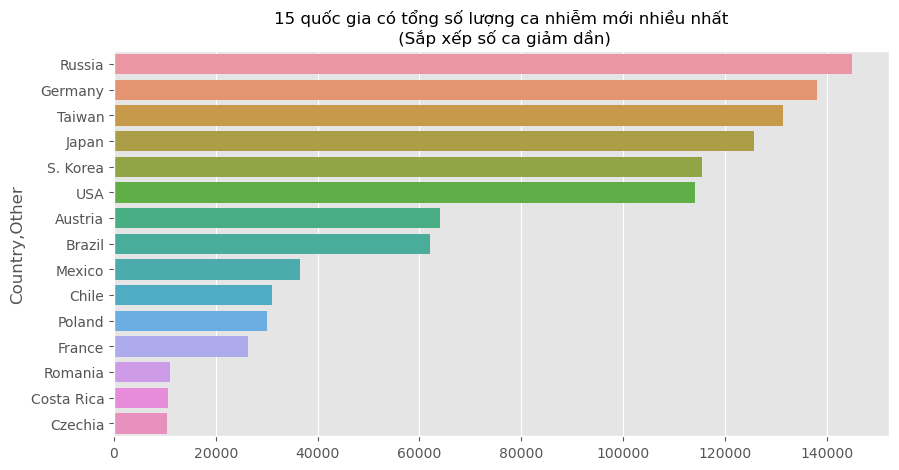

In [56]:
# filter 15 most new cases countries
most_newcases_country = country_df.groupby('Country,Other').sum()['NewCases'].sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=most_newcases_country.values, y=most_newcases_country.index)
plt.title('15 quốc gia có tổng số lượng ca nhiễm mới nhiều nhất\n (Sắp xếp số ca giảm dần)', fontsize=12);

**Nhận xét**:
* Có sự chênh lệch về số ca nhiễm mới ở 6 quốc gia đầu tiên và những quốc gia còn lại.
* 6 quốc gia đầu tiên có tổng số lượng ca nhiễm mới rất lớn (hơn 100000 ca nhiễm mới) $\to$ Xem xét 6 quốc gia này.

##### Số ca nhiễm mới của những quốc gia đó như thế nào?

In [57]:
# filter 6 most new cases countries
most_newcases_country = most_newcases_country.index[:6].to_list()
filtered_country_df = country_df[country_df['Country,Other'].str.contains('|'.join(most_newcases_country))]
filtered_country_df = filtered_country_df[['Country,Other', 'DateCollected', 'NewCases', 'NewDeaths', 'NewRecovered']].set_index('Country,Other')

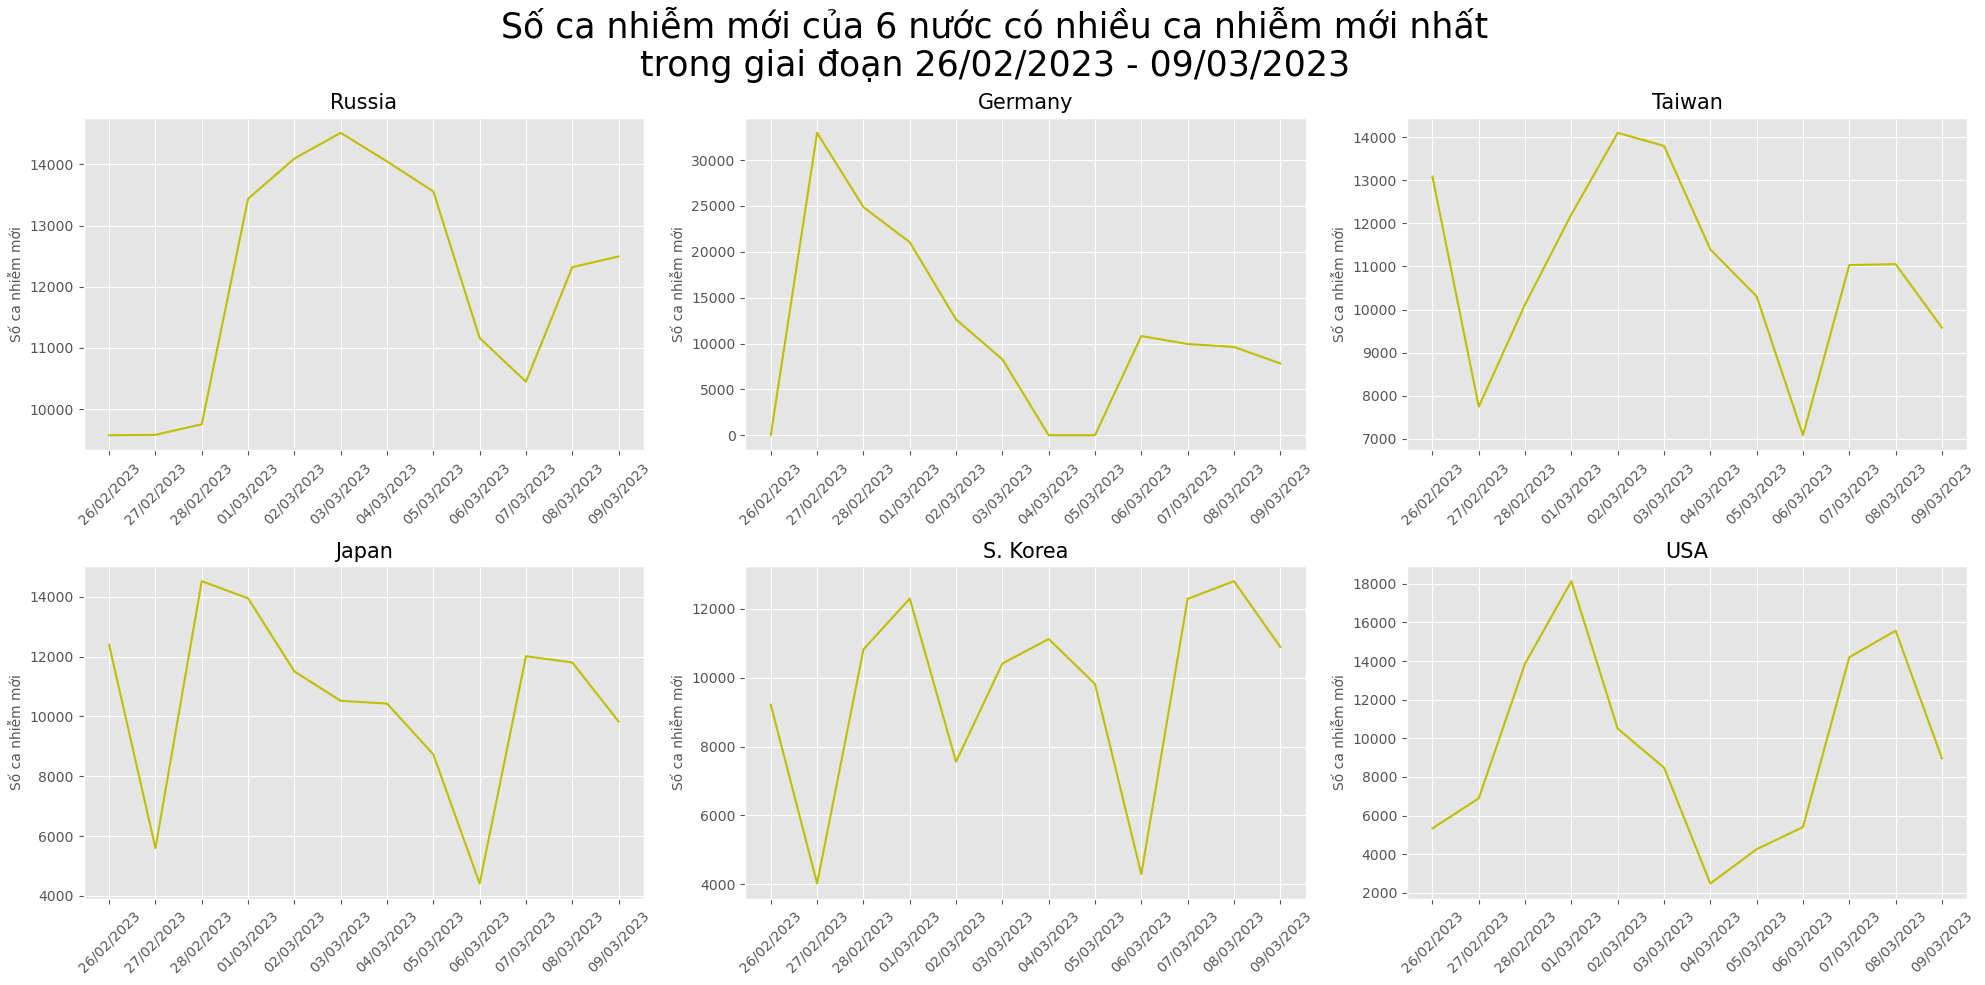

In [62]:
# get new cases of 6 countries day by day
new_cases_data = []
for country in most_newcases_country:
    new_cases_data.append(filtered_country_df.sort_values(by='DateCollected').loc[country]['NewCases'].to_list())

# get date for x_ticks
time_data = filtered_country_df['DateCollected'].unique()

# make dataframe
new_cases_df = pd.DataFrame(data=new_cases_data, index=most_newcases_country, columns=time_data)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
axes = axes.flatten()

for i, country in enumerate(most_newcases_country):
    ax = axes[i]
    sns.lineplot(data=new_cases_df.T[country], markers=True, color='y', ax=ax);
    ax.set_title(f'{country}', size=15)
    ax.set_ylabel('Số ca nhiễm mới', size=10)
    ax.set_xticks(new_cases_df.T[country].index, new_cases_df.T[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)

oldest_day = pd.to_datetime(time_data.min()).strftime('%d/%m/%Y')
newest_day = pd.to_datetime(time_data.max()).strftime('%d/%m/%Y')
plt.suptitle(f"Số ca nhiễm mới của 6 nước có nhiều ca nhiễm mới nhất\ntrong giai đoạn {oldest_day} - {newest_day}", size=25);
fig.tight_layout()

**Nhận xét**:
* Ở Đức vừa có vẻ như vừa trải qua một đợt bùng phát dịch lớn, số lượng ca nhiễm từ 0 $\to$ hơn 30000 chỉ sau 1 đêm. Tuy nhiên tình hình đã có tiến triển tốt khi số ca mắc ít đi dần theo từng ngày.
* Ở Hàn Quốc, tình hình dịch vẫn đang kéo dài và có dấu hiệu căng thẳng hơn trong khi 4 quốc gia còn lại đang có dấu hiệu suy giảm.

##### Số ca hồi phục và số ca chết mới ở những quốc gia đó như thế nào?

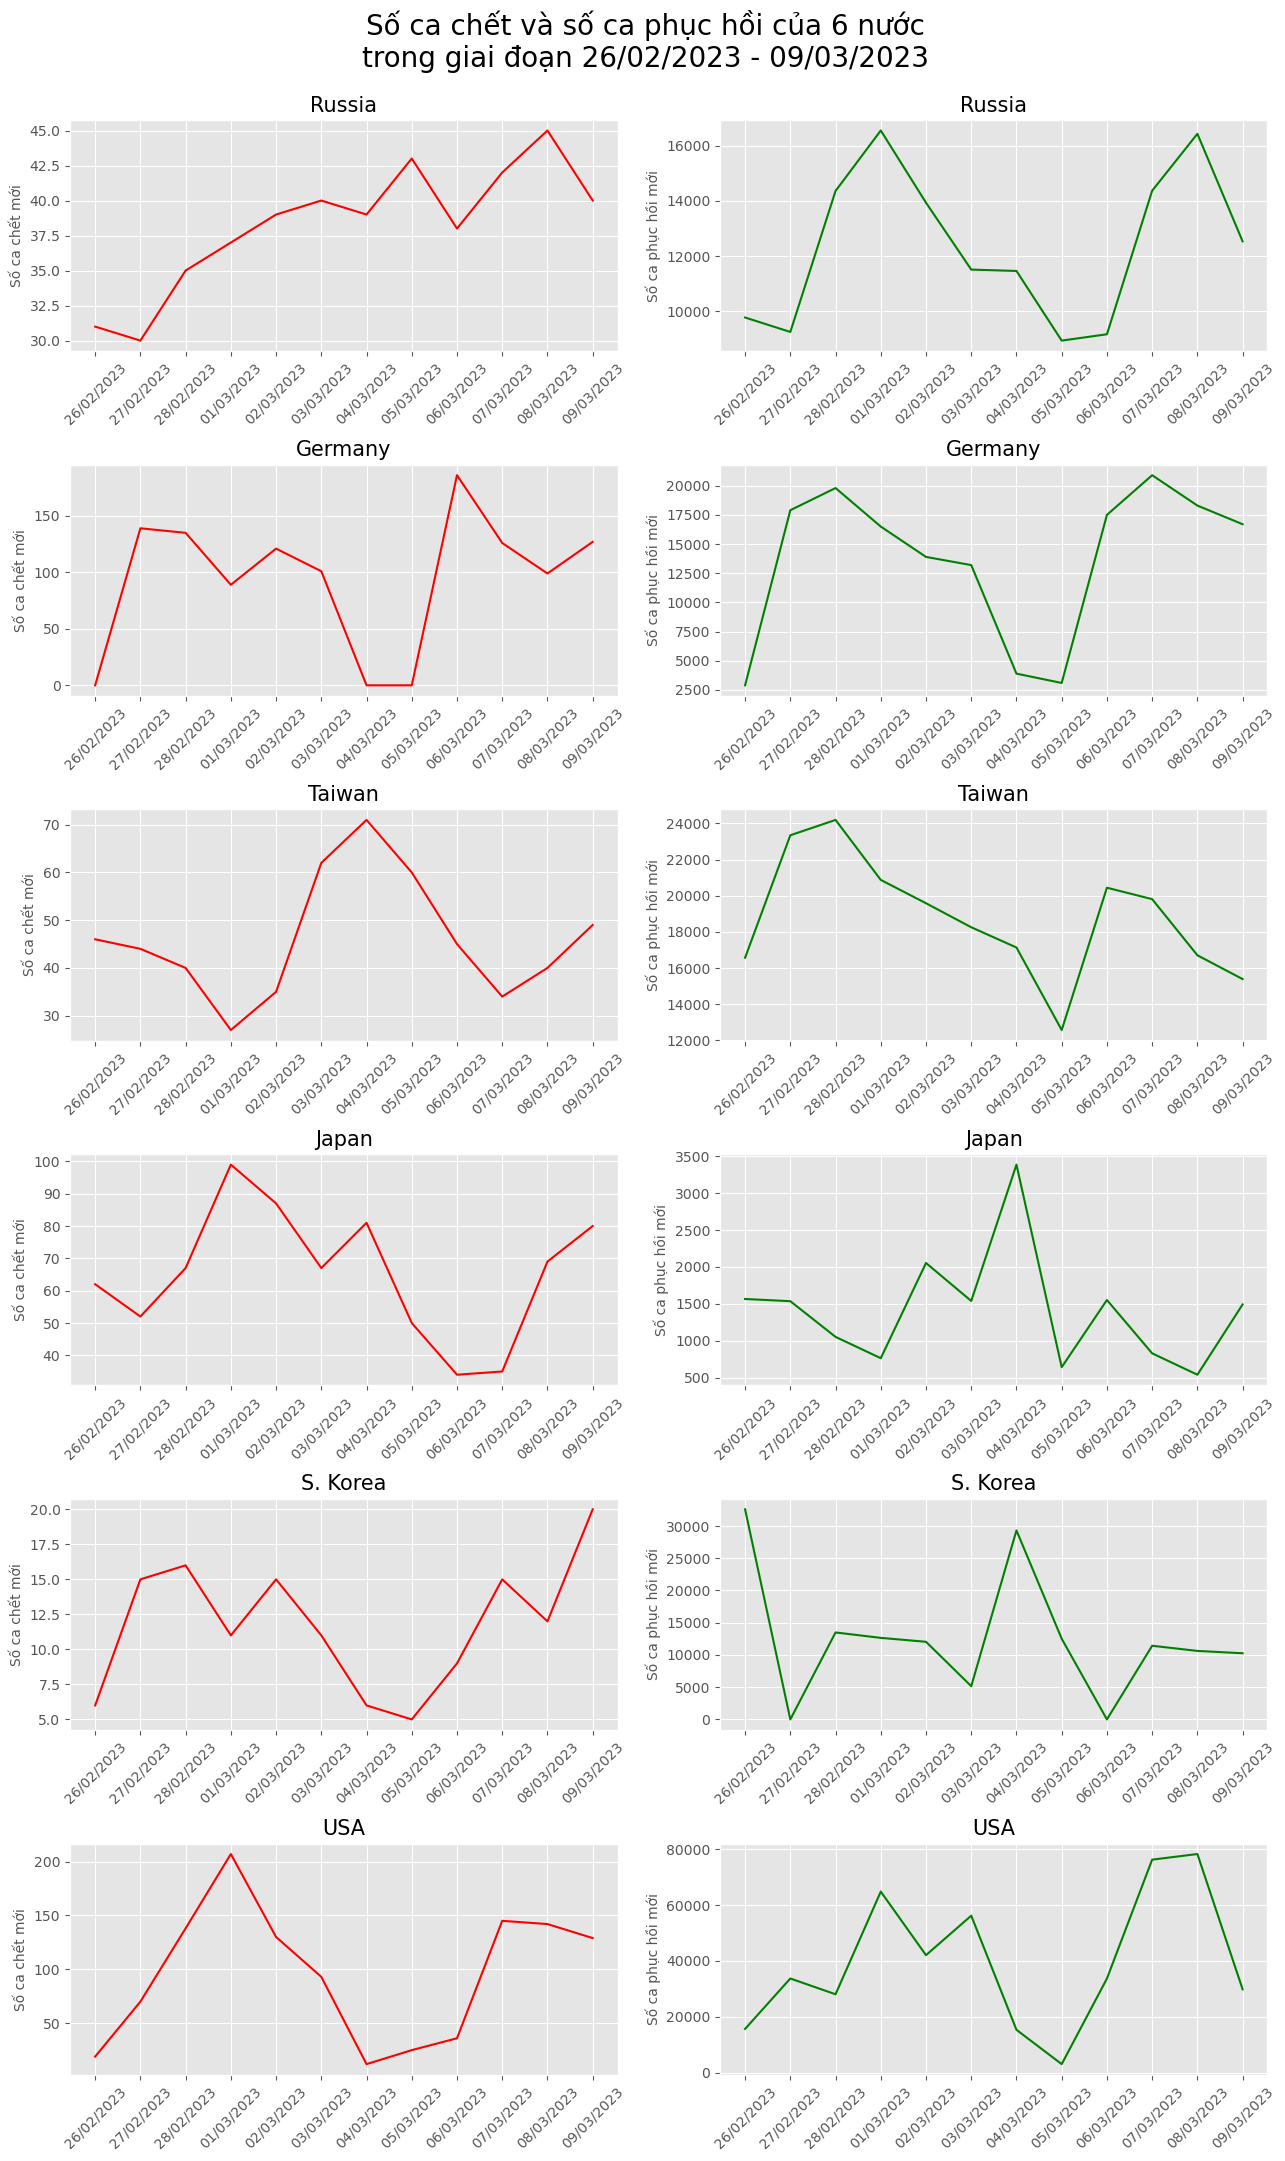

In [73]:
# get new deaths and new recovered of 6 countries day by day
new_death_data = []
new_recover_data = []
for country in most_newcases_country:
    new_death_data.append(filtered_country_df.sort_values(by='DateCollected').loc[country]['NewDeaths'].to_list())
    new_recover_data.append(filtered_country_df.sort_values(by='DateCollected').loc[country]['NewRecovered'].to_list())

# make dataframe
new_death_df = pd.DataFrame(data=new_death_data, index=most_newcases_country, columns=time_data)
new_recover_df = pd.DataFrame(data=new_recover_data, index=most_newcases_country, columns=time_data)

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13,22))

for i, country in enumerate(most_newcases_country):
    sns.lineplot(data=new_death_df.T[country], markers=True, color='r', ax=axes[i, 0]);
    axes[i, 0].set_title(f'{country}', size=15)
    axes[i, 0].set_ylabel('Số ca chết mới', size=10)
    axes[i, 0].set_xticks(new_death_df.T[country].index, new_death_df.T[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)

    sns.lineplot(data=new_recover_df.T[country], markers=True, color='g', ax=axes[i, 1]);
    axes[i, 1].set_title(f'{country}', size=15)
    axes[i, 1].set_ylabel('Số ca phục hồi mới', size=10)
    axes[i, 1].set_xticks(new_recover_df.T[country].index, new_recover_df.T[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)

plt.suptitle(f"Số ca chết và số ca phục hồi của 6 nước\ntrong giai đoạn {oldest_day} - {newest_day}", size=20);
fig.tight_layout()
fig.subplots_adjust(top=0.93)

**Nhận xét**:
* Số lượng ca chết mới ở Đài Loan đang có dấu hiệu tăng dần trong khi số ca hồi phục có dấu hiệu giảm hoặc đi ngang theo thời gian.
* Ở các nước còn lại thì số ca chết và số ca hồi phục đi ngang theo thời gian.

**Nhận xét chung**:
* Tình hình chống dịch ở Đức vẫn đang duy trì ở mức khá tốt do đã có sự suy giảm rõ rệt trong số ca nhiễm mới mỗi ngày. 
* Nhìn chung tuy tình hình dịch bệnh căng thẳng nhưng các nước vẫn làm tốt công tác phòng chống dịch. Riêng Hàn Quốc đang có dấu hiệu tệ đi khi số ca chết tăng nhưng số ca hồi phục lại giảm cùng với số ca nhiễm ở mỗi ngày đang có dấu hiệu tăng lên.

#### Tình hình dịch bệnh Covid-19 trên 5 quốc gia có tỉ lệ ca tử vong cao nhất tại thời điểm mới nhất

Các vấn đề cần quan tâm:
+ Xác định xem số ca nhiễm mới có xu hướng ra sao, có cùng thay đổi chung với số ca tử vong hay không?
+ Xác định tình hình dịch bệnh của 5 nước cũng như xem xét khả năng hồi phục có thay đổi như thế nào. Đồng thời cũng thể hiện sự tương quan giữa số ca tử vong so với số ca hồi phục


In [74]:
# filter top 5 death rate countries
final_df = df.drop(df[df['Country,Other'] == 'World'].index).reset_index(drop=True)
top_5_countries_death = final_df.sort_values('Deaths/1M pop', ascending=False)['Country,Other'].unique()[:5]
top_5_countries_death_df = final_df[final_df['Country,Other'].isin(top_5_countries_death)].reset_index(drop=True)

#### Tổng số ca tử vong

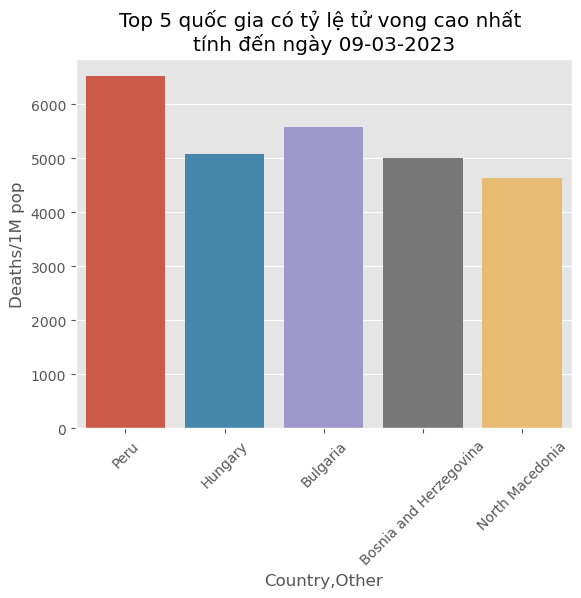

In [75]:
# filter death rate of last collected date
newest_day = top_5_countries_death_df["DateCollected"].max()
fiter_top_5_countries_death_df = top_5_countries_death_df.loc[top_5_countries_death_df["DateCollected"] == newest_day, ['Country,Other', 'Deaths/1M pop']]

fig = sns.barplot(data=fiter_top_5_countries_death_df, x='Country,Other', y='Deaths/1M pop')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);
fig.set_title(f"Top 5 quốc gia có tỷ lệ tử vong cao nhất \ntính đến ngày {newest_day.strftime('%d-%m-%Y')}");

Nhận xét:
- Nhìn chung, tỷ lệ tử vong (xét trên 1 triệu dân số) của 5 nước đều cao, trong đó Peru dẫn đầu với tổng số ca tử vong là 6000 người chết/1M


#### Tổng số ca nhiễm mới 

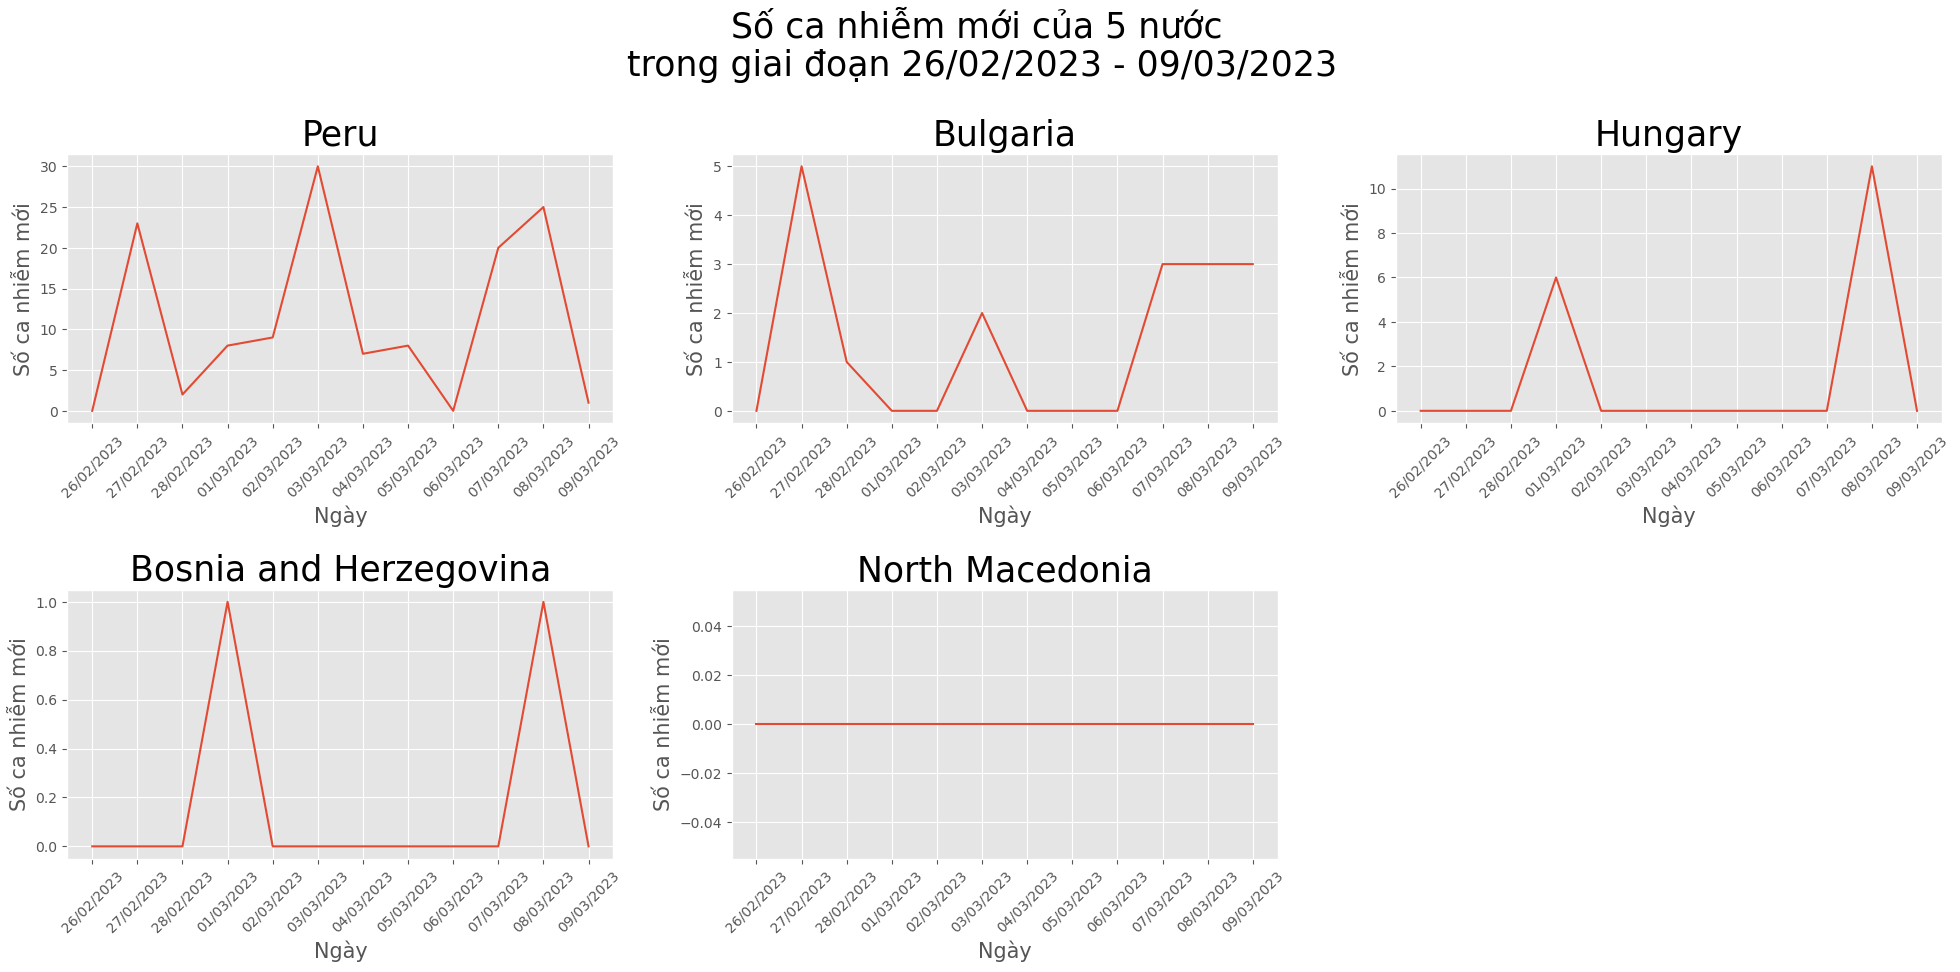

In [77]:
new_cases_df = top_5_countries_death_df.copy()
new_cases_df = new_cases_df.groupby(['Country,Other', 'DateCollected']).sum(numeric_only=True)

#draw line chart for each country
fig, axes = plt.subplots(2, 3, figsize=(20,10))
axes = axes.flatten()

for i, country in enumerate(top_5_countries_death):
    ax = axes[i]
    sns.lineplot(data=new_cases_df.loc[country], x='DateCollected', y='NewDeaths', legend=True, ax=ax)
    ax.set_title(f'{country}', size=25)
    ax.set_ylabel('Số ca nhiễm mới', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticks(new_cases_df.loc[country].index, new_cases_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)
 
oldest_day = top_5_countries_death_df["DateCollected"].min()
newest_day = top_5_countries_death_df["DateCollected"].max()

plt.suptitle(f"Số ca nhiễm mới của 5 nước \ntrong giai đoạn {oldest_day.strftime('%d/%m/%Y')} - {newest_day.strftime('%d/%m/%Y')}", size=25);
fig.delaxes(axes[2*3-1])
fig.tight_layout(pad=2)

**Nhận xét**

* Số ca nhiễm mới của 2 nước Peru và Bulgaria biến động khá lớn, trong khi đó nước North Macedonia không ghi nhận thêm ca nhiễm mới nào
* Nước Hungary có số ca nhiễm mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và 8/3/2023, khu vực Bosnia and Herzegovina có số ca nhiễm mới đạt đỉnh điểm vào 2 ngày 28/2/2023 và 8/3/2023

#### Tỷ lệ số ca tử vong và số ca hồi phục

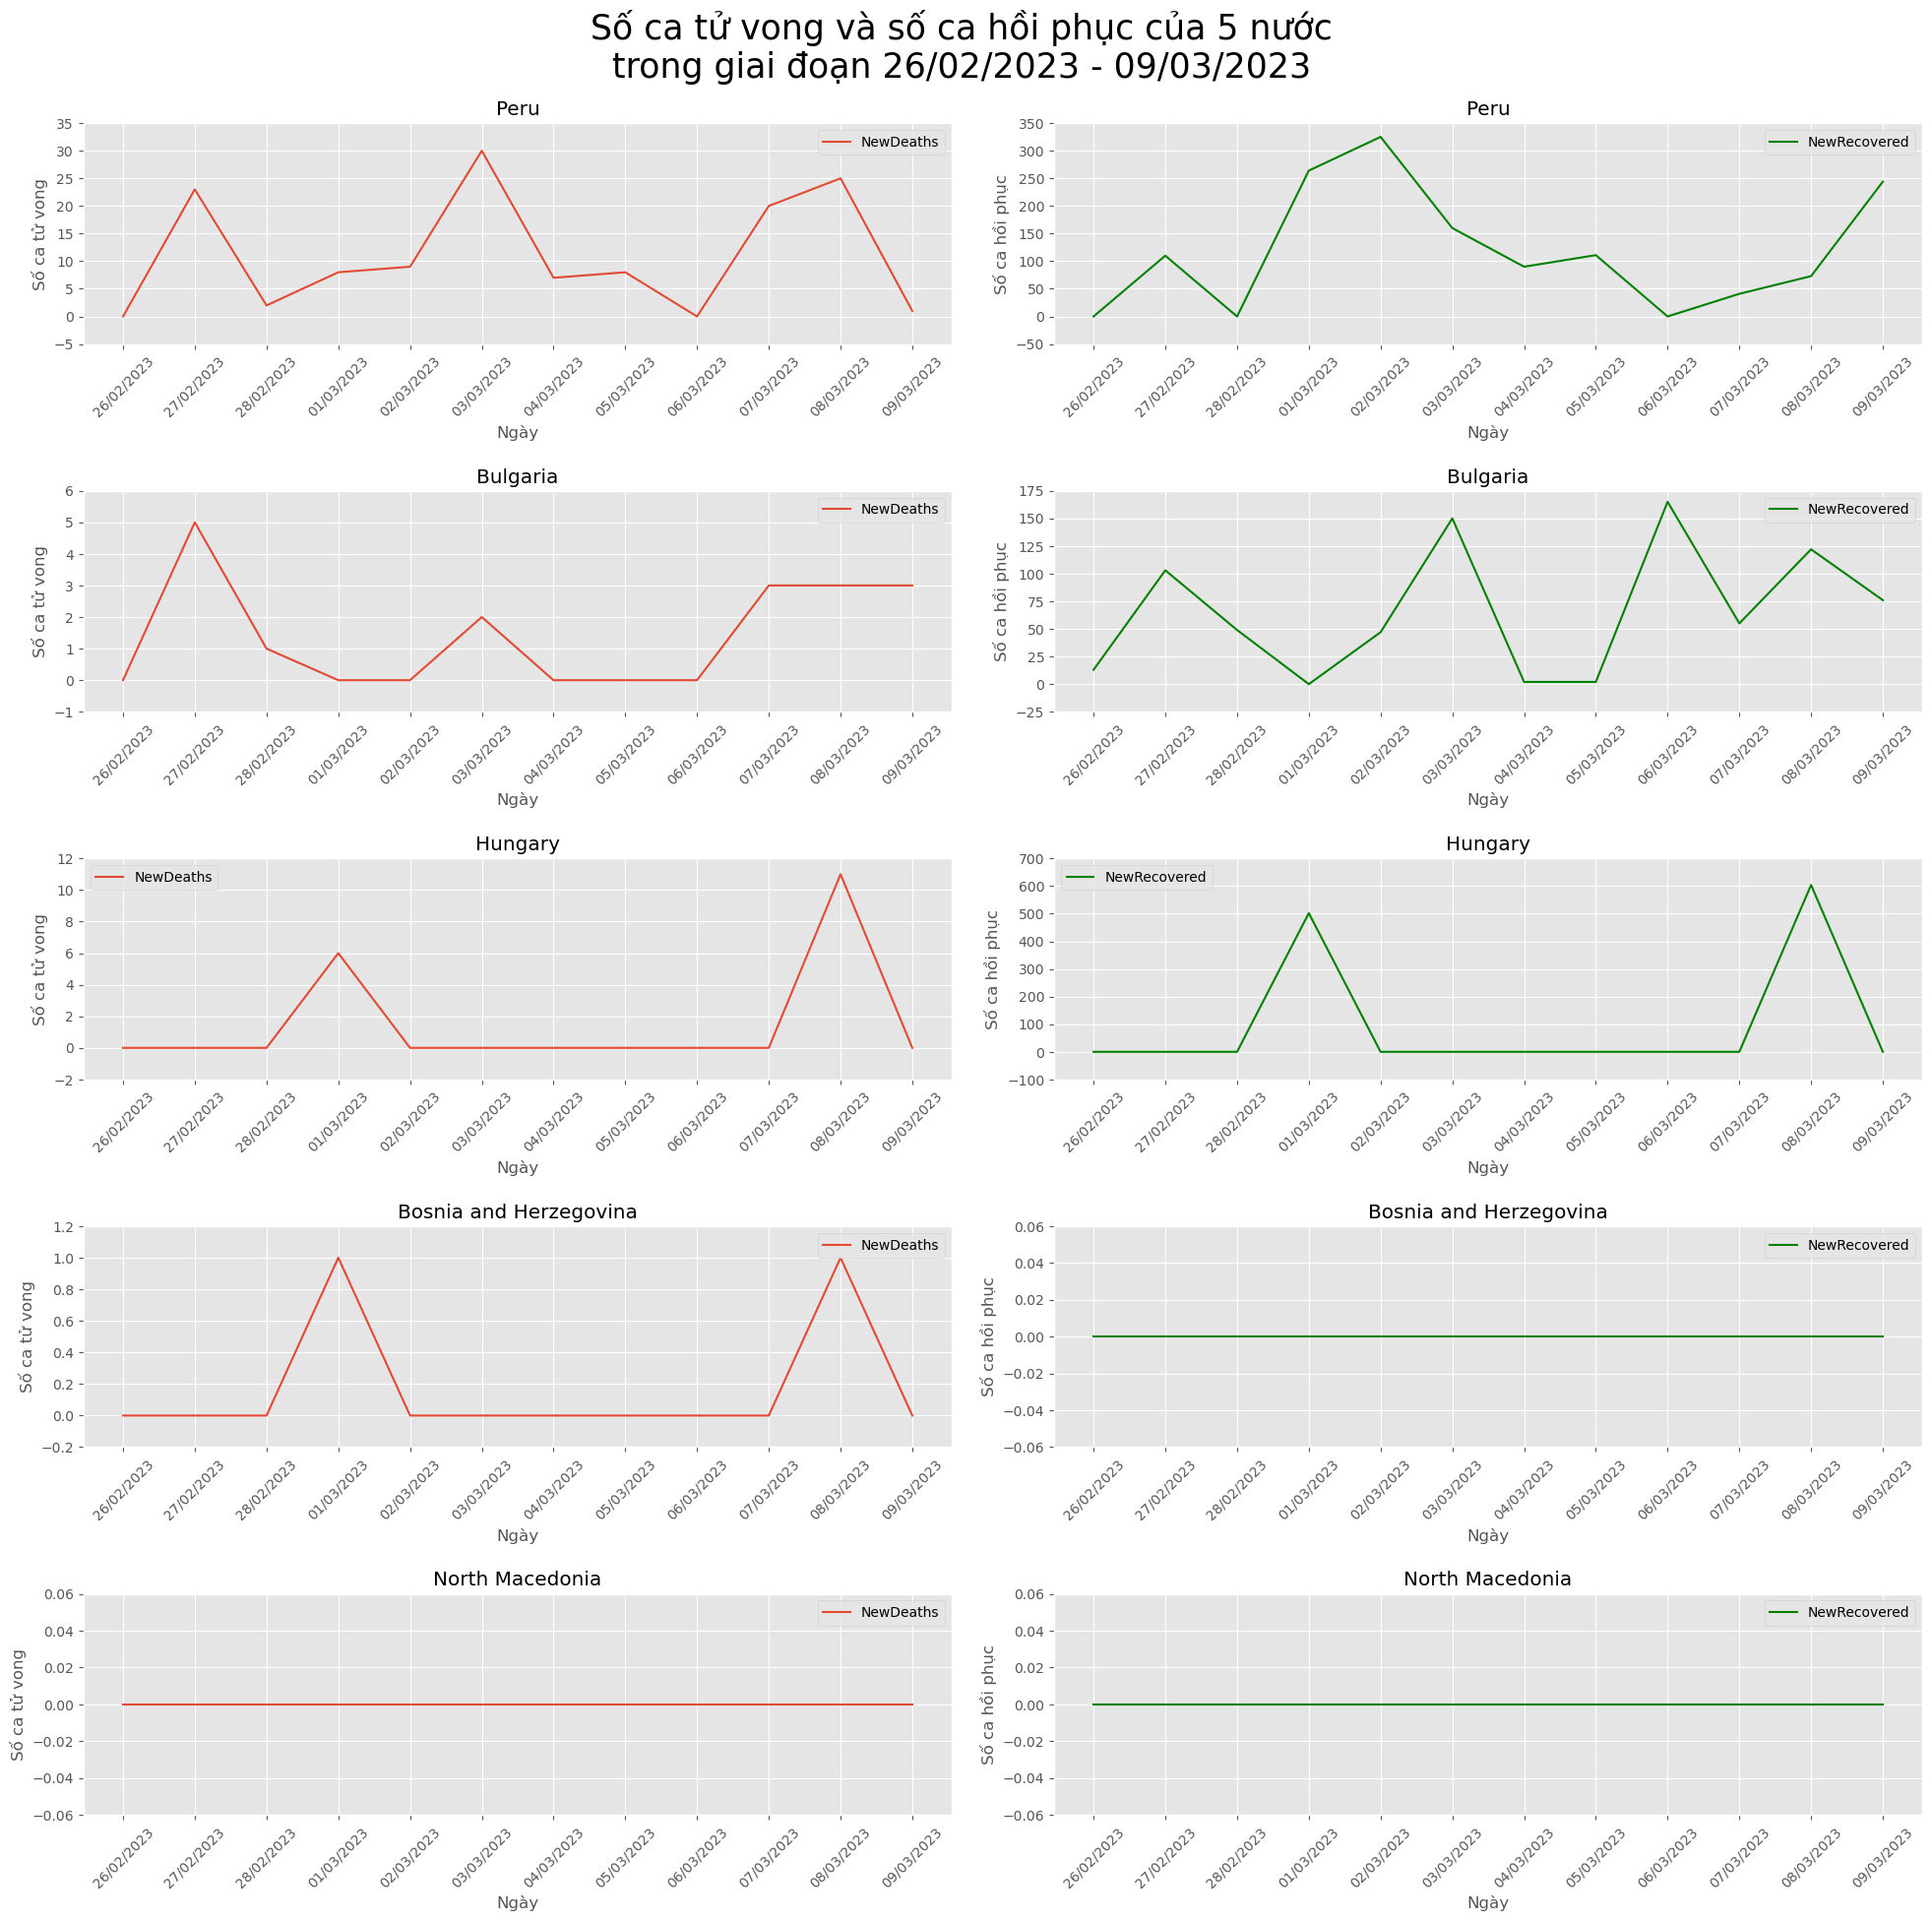

In [48]:
trend_top_5_countries_death_df = top_5_countries_death_df.groupby(['Country,Other', 'DateCollected']).sum(numeric_only=True)
fig, axes = plt.subplots(5, 2, figsize=(20,20))

for i, country in enumerate(top_5_countries_death):
    sns.lineplot(data=trend_top_5_countries_death_df.loc[country], x='DateCollected', y='NewDeaths', legend=True, ax=axes[i, 0])
    sns.lineplot(data=trend_top_5_countries_death_df.loc[country], x='DateCollected', y='NewRecovered', ax=axes[i, 1], legend=True, color='g')
    axes[i, 0].set_title(f'{country}')
    axes[i, 0].set_ylabel('Số ca tử vong')
    axes[i, 0].set_xlabel('Ngày')
    axes[i, 0].set_yticks(axes[i, 0].get_yticks())
    axes[i, 0].set_xticks(trend_top_5_countries_death_df.loc[country].index, trend_top_5_countries_death_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)
    axes[i, 0].legend(['NewDeaths'])

    axes[i, 1].set_ylabel('Số ca hồi phục')
    axes[i, 1].set_title(f'{country}')
    axes[i, 1].set_xlabel('Ngày')
    axes[i, 1].set_yticks(axes[i, 1].get_yticks())
    axes[i, 1].set_xticks(trend_top_5_countries_death_df.loc[country].index, trend_top_5_countries_death_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)
    axes[i, 1].legend(['NewRecovered'])

oldest_day = top_5_countries_death_df["DateCollected"].min()
newest_day = top_5_countries_death_df["DateCollected"].max()

fig.suptitle(f"Số ca tử vong và số ca hồi phục của 5 nước \ntrong giai đoạn {oldest_day.strftime('%d/%m/%Y')} - {newest_day.strftime('%d/%m/%Y')} ", size=25)
fig.tight_layout(pad=2)

**Nhận xét**

- Nhìn chung, số ca tử vong của 5 nước có tỉ lệ tử vong cao nhất có xu hướng giảm 

- Về số ca tử vong mới, 2 nước Peru và Bulgaria có số ca tử vong mới biến động khá lớn và đạt giá trị khá cao so với các nước còn lại. Trong khi đó North Macedonia không ghi nhận thêm ca tử vong mới nào. Nước Hungary và khu vực Bosnia và Herzegovina có số ca tử vong mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và 8/3/2023

- Về số ca hồi phục mới, 2 nước Peru và Bulgaria cũng có số ca hồi phục mới biến động mạnh và đạt giá trị khá cao so với các nước còn lại. Trong khi đó North Macedonia và khu vực Bosnia và Herzegovina không ghi nhận thêm ca hồi phục mới nào. Nước Hungary có số ca hồi phục mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và 8/3/2023


#### Tổng số ca test

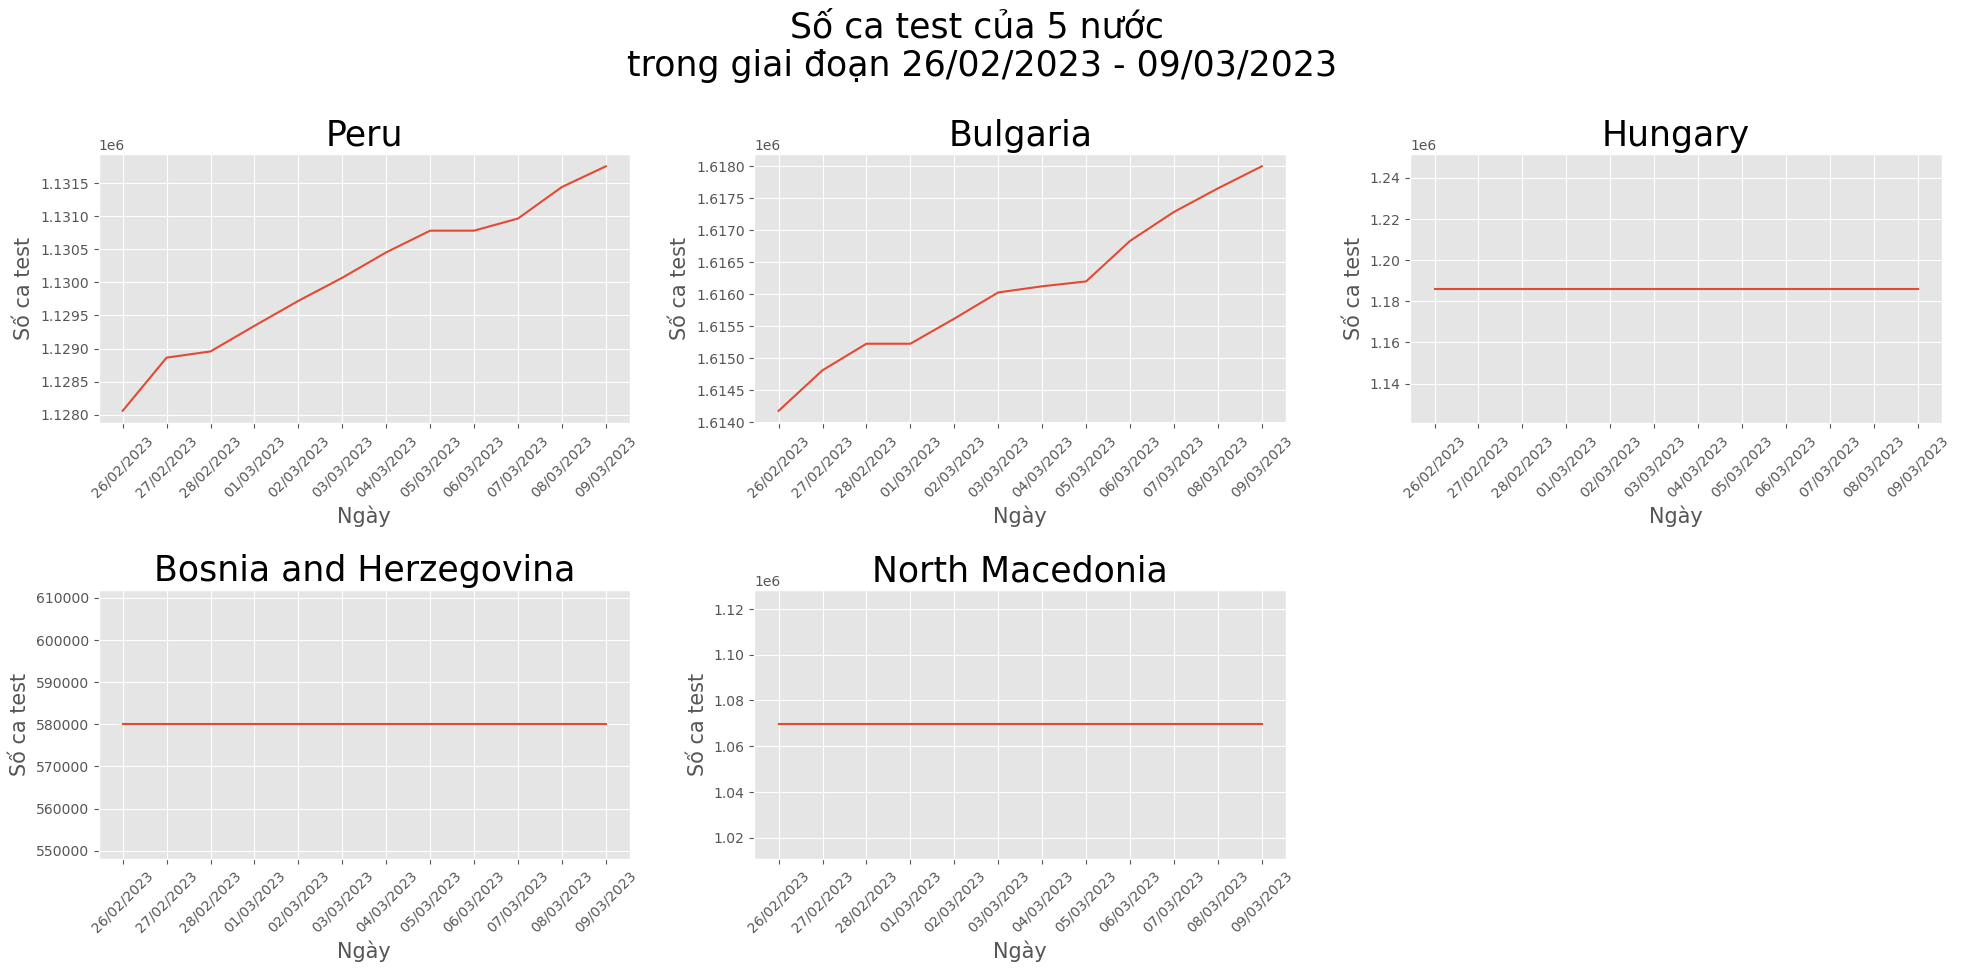

In [49]:
# get test rate of 5 country day by day
test_situations_df = top_5_countries_death_df.groupby(['Country,Other', 'DateCollected']).sum(numeric_only=True)
test_situations_df = test_situations_df.loc[top_5_countries_death, ['Tests/ 1M pop']]

fig, axes = plt.subplots(2, 3, figsize=(20,10))
axes = axes.flatten()

for i, country in enumerate(top_5_countries_death):
    ax = axes[i]
    sns.lineplot(data=test_situations_df.loc[country], x='DateCollected', y='Tests/ 1M pop', legend=True, ax=ax)
    ax.set_title(f'{country}', size=25)
    ax.set_ylabel('Số ca test', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticks(test_situations_df.loc[country].index, test_situations_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)

        
oldest_day = top_5_countries_death_df["DateCollected"].min()
newest_day = top_5_countries_death_df["DateCollected"].max()

plt.suptitle(f"Số ca test của 5 nước \ntrong giai đoạn {oldest_day.strftime('%d/%m/%Y')} - {newest_day.strftime('%d/%m/%Y')}", size=25);
fig.delaxes(axes[2*3-1])
fig.tight_layout(pad=2)

**Nhận xét**

- Vì số ca tử vong ở nước Peru biến động mạnh và đạt giá trị cao, do đó chính phủ đã tăng cường kiểm soát dịch bệnh bằng việc thực hiện việc test, từ biểu đồ cho thấy số ca test tăng mạnh, cao nhất là 1,13 triệu ca/ngày. Bên cạnh đó, nước Bulgaria cũng có tỷ lệ thực hiện test khá cao

- Ngoài ra, tỷ lệ ca test ở các nước Hungary, Bosnia and Herzegovina, North Macedonia cũng đạt mức cao nhưng không tăng dần theo thời gian


**Nhận xét chung**
- Từ biểu đồ tỷ lệ số ca hồi phục và số ca tử vong, ta thấy nước Hungary có số ca tử vong mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và ngày 8/3/2023, và trong 2 ngày này, số ca hồi phục ở quốc gia này cũng đạt đỉnh điểm, điều đó cho thấy công tác phòng chống dịch tại Hungary được tăng cường mạnh vào 2 mốc thời gian này
- Cũng vào mốc thời gian này, số ca tử vong ở khu vực Bosnia and Herzegovina cũng tăng đột biến, nhưng số ca hồi phục lại không được ghi nhận thêm
- Tại quốc gia Peru, số ca nhiễm mới và số ca tử vong đồng thời tăng đột biến vào ngày 3/3/2023 cho thấy tình hình dịch bệnh ở quốc gia này đang diễn biến phức tạp vào thời gian này